<a href="https://colab.research.google.com/github/celsoneto2002/TrabalhoBigData/blob/main/TrabalhoBIGDATA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()  # selecione os 3 CSVs (2023, 2024, 2025)
list(uploaded.keys())


In [ ]:
import pandas as pd

MONTHS_PT = ["Jan","Fev","Mar","Abr","Mai","Jun","Jul","Ago","Set","Out","Nov","Dez"]

def detect_header_row(path, encoding="latin-1"):
    """Acha a linha do cabeçalho (onde aparecem 'Ano' e os meses)"""
    with open(path, "r", encoding=encoding) as f:
        for i, line in enumerate(f):
            if ";" in line and "Ano" in line and any(m in line for m in MONTHS_PT):
                return i
    raise RuntimeError(f"Não encontrei o cabeçalho em: {path}")

def parse_numeric_series_safe(s: pd.Series) -> pd.Series:
    """Converte strings numéricas tratando: vazio, '-', vírgula como decimal e ponto como milhar."""
    s = s.astype(str).str.strip().replace({"-": "0", "": "0"})
    mask_comma = s.str.contains(",", regex=False)               # tem vírgula? (então vírgula é decimal)
    s_commas = s[mask_comma].str.replace(".", "", regex=False).str.replace(",", ".", regex=False)
    s_no_commas = s[~mask_comma]                                # aqui o ponto é decimal (não removemos)
    s_final = pd.concat([s_commas, s_no_commas]).sort_index()
    return pd.to_numeric(s_final, errors="coerce").fillna(0).round().astype(int)

def load_sinan_auto(path: str) -> pd.DataFrame:
    """Lê CSV SINAN (formato TabNet), padroniza colunas, remove 'Total' e devolve no formato longo (Ano, Mês, Casos)."""
    header_row = detect_header_row(path)
    df = pd.read_csv(path, sep=";", encoding="latin-1", header=header_row, quotechar='"')
    df = df.rename(columns={df.columns[0]: "Ano"})
    # mantém apenas linhas numéricas e 'Total'
    df = df[df["Ano"].astype(str).str.match(r"^\d{4}$|^Total$", na=False)]
    # remove coluna Total se existir
    if "Total" in df.columns:
        df = df.drop(columns=["Total"])
    # normaliza números
    for col in df.columns[1:]:
        df[col] = parse_numeric_series_safe(df[col])
    # remove linha 'Total'
    df = df[~df["Ano"].astype(str).str.fullmatch("Total")]
    df["Ano"] = df["Ano"].astype(int)
    # mantém meses na ordem certa
    cols = ["Ano"] + [m for m in MONTHS_PT if m in df.columns]
    df = df[cols]
    # wide -> long
    df_long = df.melt(id_vars=["Ano"], var_name="Mês", value_name="Casos")
    df_long["Mês"] = pd.Categorical(df_long["Mês"], categories=MONTHS_PT, ordered=True)
    return df_long.sort_values(["Ano","Mês"]).reset_index(drop=True)


In [ ]:
import io

dfs = []
for name, content in uploaded.items():
    with open(name, "wb") as f:
        f.write(content)                 # grava o arquivo no runtime do Colab
    dfs.append(load_sinan_auto(name))    # lê e trata

df = pd.concat(dfs, ignore_index=True)
df.head()


,Ano,Mês,Casos
0,2023,Jan,67621
1,2023,Fev,133460
2,2023,Mar,312726
3,2023,Abr,399750
4,2023,Mai,277199


,Ano,Casos,Frequência (%)
0,2023,1508653,15.96
1,2024,6421942,67.92
2,2025,1524230,16.12


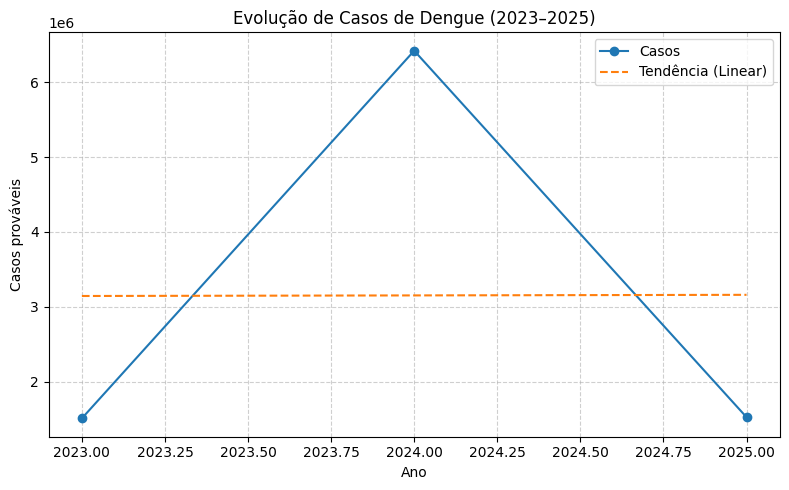

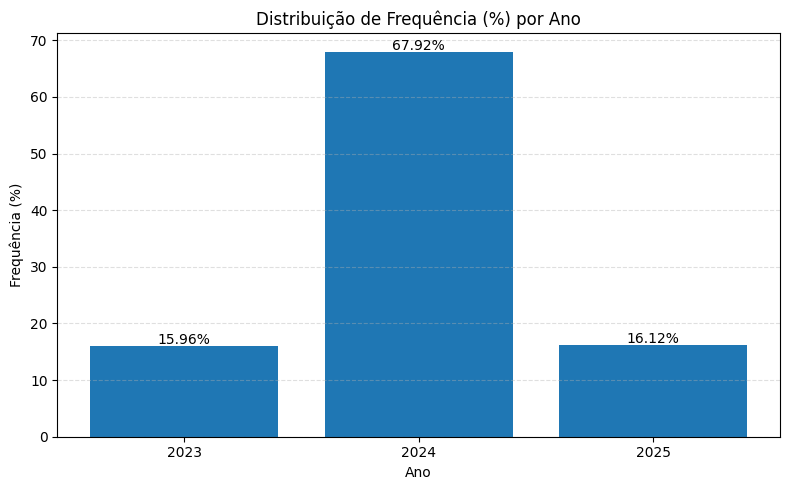

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tabela anual consolidada
df_anual = df.groupby("Ano", as_index=False)["Casos"].sum()
df_anual["Frequência (%)"] = (df_anual["Casos"] / df_anual["Casos"].sum() * 100).round(2)
display(df_anual)

# Regressão linear (tendência)
x = df_anual["Ano"].values.astype(float)
y = df_anual["Casos"].values.astype(float)
m, b = np.polyfit(x, y, 1)
y_pred = m*x + b

# Evolução anual
plt.figure(figsize=(8,5))
plt.plot(df_anual["Ano"], df_anual["Casos"], marker="o", label="Casos")
plt.plot(df_anual["Ano"], y_pred, linestyle="--", label="Tendência (Linear)")
plt.title("Evolução de Casos de Dengue (2023–2025)")
plt.xlabel("Ano")
plt.ylabel("Casos prováveis")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("grafico_evolucao_anual.png", dpi=150)
plt.show()

# Frequência anual
plt.figure(figsize=(8,5))
plt.bar(df_anual["Ano"].astype(str), df_anual["Frequência (%)"])
for i, v in enumerate(df_anual["Frequência (%)"]):
    plt.text(i, v + 0.4, f"{v}%", ha="center")
plt.title("Distribuição de Frequência (%) por Ano")
plt.xlabel("Ano")
plt.ylabel("Frequência (%)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("grafico_frequencia_anual.png", dpi=150)
plt.show()


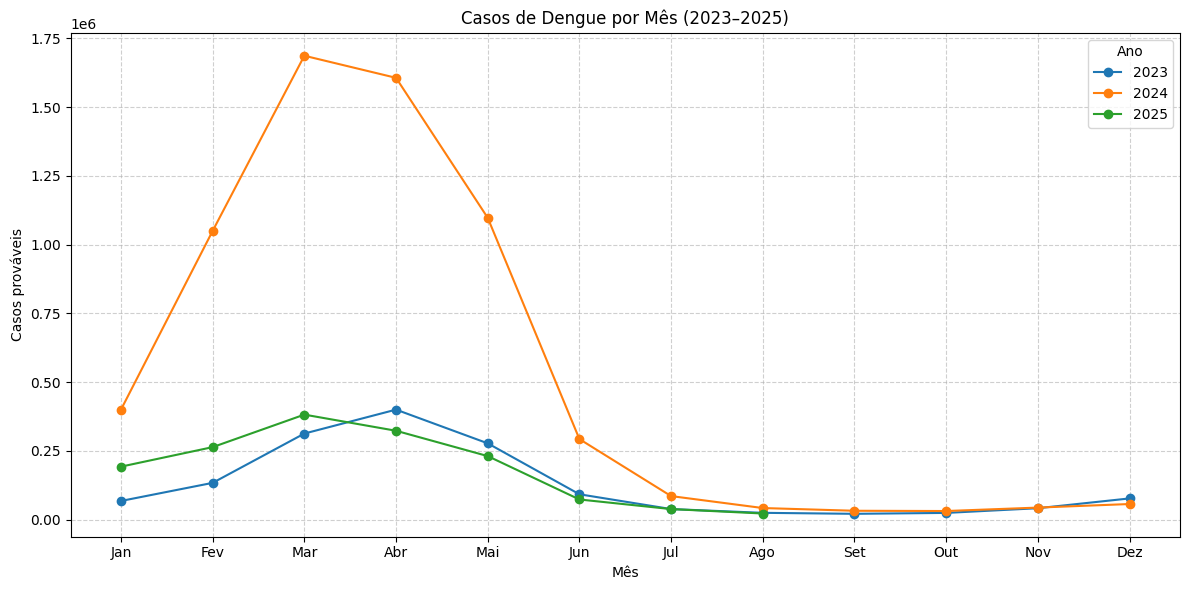

In [ ]:
plt.figure(figsize=(12,6))
for ano in sorted(df["Ano"].unique()):
    dados = df[df["Ano"] == ano]
    plt.plot(dados["Mês"].astype(str), dados["Casos"], marker="o", label=str(ano))

plt.title("Casos de Dengue por Mês (2023–2025)")
plt.xlabel("Mês")
plt.ylabel("Casos prováveis")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Ano")
plt.tight_layout()
plt.savefig("grafico_evolucao_mensal_23_25.png", dpi=150)
plt.show()


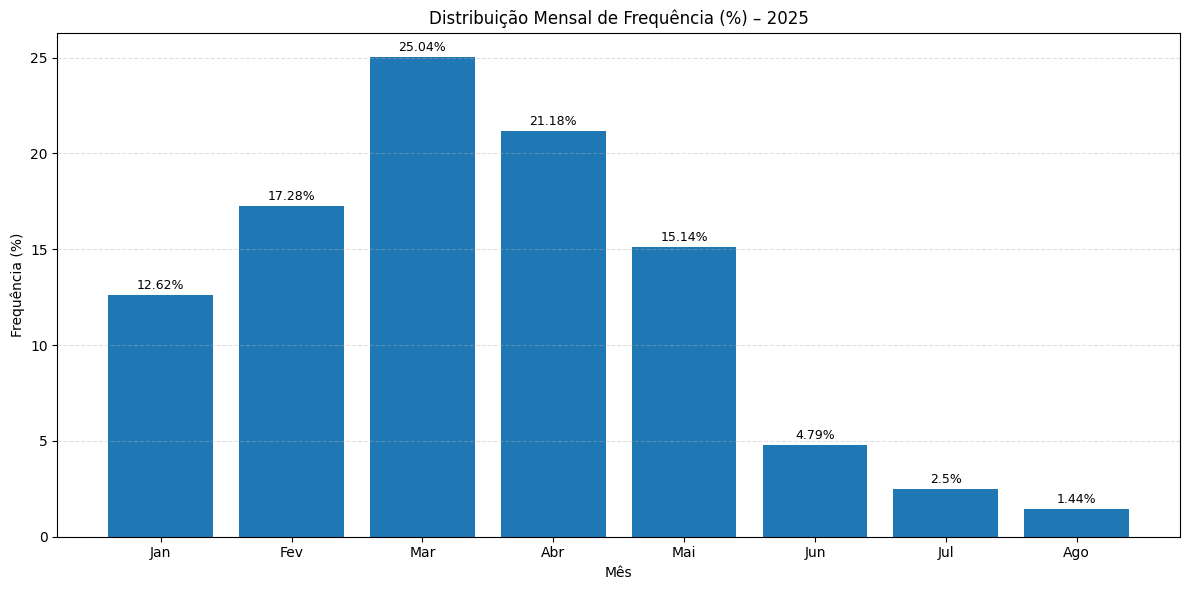

In [ ]:
ano_focus = 2025  # pode trocar para 2023, 2024 ou 2025

df_focus = df[df["Ano"] == ano_focus].copy()
total_focus = df_focus["Casos"].sum()
df_focus["Frequência (%)"] = (df_focus["Casos"] / total_focus * 100).round(2)

plt.figure(figsize=(12,6))
plt.bar(df_focus["Mês"].astype(str), df_focus["Frequência (%)"])
for i, v in enumerate(df_focus["Frequência (%)"]):
    plt.text(i, v + 0.3, f"{v}%", ha="center", fontsize=9)

plt.title(f"Distribuição Mensal de Frequência (%) – {ano_focus}")
plt.xlabel("Mês")
plt.ylabel("Frequência (%)")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig(f"grafico_frequencia_mensal_{ano_focus}.png", dpi=150)
plt.show()


In [ ]:
df.to_csv("dengue_2023_2025_mensal_tratado.csv", index=False, encoding="utf-8")
df_anual.to_csv("dengue_2023_2025_anual_tratado.csv", index=False, encoding="utf-8")
print("Arquivos gerados: dengue_2023_2025_mensal_tratado.csv, dengue_2023_2025_anual_tratado.csv")


Arquivos gerados: dengue_2023_2025_mensal_tratado.csv, dengue_2023_2025_anual_tratado.csv
